In [19]:
import pandas as pd
import os
import igraph as ig
from IPython.display import display
import numpy as np

In [7]:
# Define path to dataset folder
dataset_path = "/Users/gergoar/Documents/Ger Goar/Maestría BCN/BSE/Term 2/Networks/Project/FakeNewsNet/dataset"



In [8]:
# Load Politifact dataset
politifact_fake = pd.read_csv(os.path.join(dataset_path, "politifact_fake.csv"))
politifact_real = pd.read_csv(os.path.join(dataset_path, "politifact_real.csv"))

# Load GossipCop dataset
gossipcop_fake = pd.read_csv(os.path.join(dataset_path, "gossipcop_fake.csv"))
gossipcop_real = pd.read_csv(os.path.join(dataset_path, "gossipcop_real.csv"))

# Display the first few rows
politifact_fake.head()


,id,news_url,title,tweet_ids
0,politifact15014,speedtalk.com/forum/viewtopic.php?t=51650,BREAKING: First NFL Team Declares Bankruptcy O...,937349434668498944\t937379378006282240\t937380...
1,politifact15156,politics2020.info/index.php/2018/03/13/court-o...,Court Orders Obama To Pay $400 Million In Rest...,972666281441878016\t972678396575559680\t972827...
2,politifact14745,www.nscdscamps.org/blog/category/parenting/467...,UPDATE: Second Roy Moore Accuser Works For Mic...,929405740732870656\t929439450400264192\t929439...
3,politifact14355,https://howafrica.com/oscar-pistorius-attempts...,Oscar Pistorius Attempts To Commit Suicide,886941526458347521\t887011300278194176\t887023...
4,politifact15371,http://washingtonsources.org/trump-votes-for-d...,Trump Votes For Death Penalty For Being Gay,915205698212040704\t915242076681506816\t915249...


In [ ]:
# Check dataset info
politifact_fake.info()

# Count number of fake and real news articles
print("Fake news in Politifact:", len(politifact_fake))
print("Real news in Politifact:", len(politifact_real))

print("Fake news in GossipCop:", len(gossipcop_fake))
print("Real news in GossipCop:", len(gossipcop_real))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 432 entries, 0 to 431
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         432 non-null    object
 1   news_url   428 non-null    object
 2   title      432 non-null    object
 3   tweet_ids  392 non-null    object
dtypes: object(4)
memory usage: 13.6+ KB
Fake news in Politifact: 432
Real news in Politifact: 624
Fake news in GossipCop: 5323
Real news in GossipCop: 16817


In [ ]:
import pandas as pd
import os
from IPython.display import display

# Function to extract tweet IDs and include fake/real label
def extract_tweet_ids(df, label, source):
    """
    Extracts tweet IDs from a given dataset.

    Args:
    df (DataFrame): DataFrame containing the dataset.
    label (str): 'fake' or 'real'.
    source (str): 'politifact' or 'gossipcop'.

    Returns:
    DataFrame: Processed DataFrame with 'news_id', 'tweet_id', 'label', and 'source'.
    """
    tweet_data = []

    for index, row in df.iterrows():
        news_id = row['id']  # Unique news identifier
        if pd.notna(row['tweet_ids']):  # Check if tweet_ids is not empty
            tweet_ids = str(row['tweet_ids']).split("\t")  # Split tab-separated tweet IDs
            for tweet_id in tweet_ids:
                tweet_data.append((news_id, tweet_id, label, source))

    return pd.DataFrame(tweet_data, columns=['news_id', 'tweet_id', 'label', 'source'])





In [ ]:
# Process Politifact dataset
politifact_fake_tweets = extract_tweet_ids(politifact_fake, "fake", "politifact")
politifact_real_tweets = extract_tweet_ids(politifact_real, "real", "politifact")

# Process GossipCop dataset
gossipcop_fake_tweets = extract_tweet_ids(gossipcop_fake, "fake", "gossipcop")
gossipcop_real_tweets = extract_tweet_ids(gossipcop_real, "real", "gossipcop")

# Combine all tweet data
all_tweets = pd.concat([politifact_fake_tweets, politifact_real_tweets,
                        gossipcop_fake_tweets, gossipcop_real_tweets])

# Display results
display(all_tweets.head())



,news_id,tweet_id,label,source
0,politifact15014,937349434668498944,fake,politifact
1,politifact15014,937379378006282240,fake,politifact
2,politifact15014,937380068590055425,fake,politifact
3,politifact15014,937384406511005696,fake,politifact
4,politifact15014,937387493451862016,fake,politifact


In [ ]:
# # Save to CSV for further use
# all_tweets.to_csv("extracted_tweet_ids_with_labels.csv", index=False)
# print("Extracted tweet IDs with labels saved to 'extracted_tweet_ids_with_labels.csv'")

Extracted tweet IDs with labels saved to 'extracted_tweet_ids_with_labels.csv'


In [9]:
# Load extracted tweet IDs with labels
data_path = "/Users/gergoar/Documents/Ger Goar/Maestría BCN/BSE/Term 2/Networks/Project/FakeNewsNet/extracted_tweet_ids_with_labels.csv"
df = pd.read_csv(data_path)

# Count how many times each user appears
user_counts = df["tweet_id"].value_counts()

# Keep only users that have shared more than one article (they contribute to projections)
active_users = user_counts[user_counts > 1].index.tolist()

# Filter dataset
filtered_df = df[df["tweet_id"].isin(active_users)]

df = filtered_df
df.shape


(187701, 4)

# Reliability Score

In [23]:
# Group by 'tweet_id' and 'label' and count occurrences
count_all_tweets = df.groupby(['tweet_id', 'label']).size().reset_index(name='count')

# Now 'count_all_tweets' will have columns: tweet_id, label, and count
# If you want to have a wide format with one column for real and one for fake:
count_all_tweets_pivot = count_all_tweets.pivot_table(index='tweet_id', columns='label', values='count', fill_value=0)

# Reset the index if you want it to look like a standard DataFrame
count_all_tweets_pivot.reset_index(inplace=True)

# If you want to display or use the final result
count_all_tweets_pivot.head()

label,tweet_id,fake,real
0,770674889,0.0,2.0
1,919129974,0.0,2.0
2,961839128,0.0,2.0
3,2177086266,3.0,0.0
4,2761266599,0.0,2.0


In [26]:
# Assuming count_all_tweets_pivot is the DataFrame with tweet_id, real, and fake counts
# Fill missing values with 0 if some people didn't share fake or real news
count_all_tweets_pivot.fillna(0, inplace=True)

# Normalize fake news count by dividing by the max fake news count
max_fake = count_all_tweets_pivot['fake'].max()
count_all_tweets_pivot['fake_normalized'] = count_all_tweets_pivot['fake'] / max_fake

# Normalize real news count by dividing by the max real news count
max_real = count_all_tweets_pivot['real'].max()
count_all_tweets_pivot['real_normalized'] = count_all_tweets_pivot['real'] / max_real

# Create the final score: sum of normalized real and fake news counts
# You can modify this to give more weight to real news if desired
count_all_tweets_pivot['score'] = count_all_tweets_pivot['real_normalized'] - count_all_tweets_pivot['fake_normalized']

# Optional: Sort by score in descending order to get a ranking
count_all_tweets_pivot.sort_values(by='score', ascending=False, inplace=True)

# Reset index to have a clean DataFrame
count_all_tweets_pivot.reset_index(drop=True, inplace=True)

display(count_all_tweets_pivot)

label,tweet_id,fake,real,fake_normalized,real_normalized,score
0,1064856414563241984,0.0,6.0,0.0,1.000000,1.000000
1,1056476847045668865,0.0,6.0,0.0,1.000000,1.000000
2,1064788545712332800,0.0,4.0,0.0,0.666667,0.666667
3,1025023193054994432,0.0,4.0,0.0,0.666667,0.666667
4,1055438790356017152,0.0,4.0,0.0,0.666667,0.666667
...,...,...,...,...,...,...
73280,931377999676624897,18.0,0.0,1.0,0.000000,-1.000000
73281,1011741942785499137,18.0,0.0,1.0,0.000000,-1.000000
73282,914513120189669377,18.0,0.0,1.0,0.000000,-1.000000
73283,1035239187300184065,18.0,0.0,1.0,0.000000,-1.000000


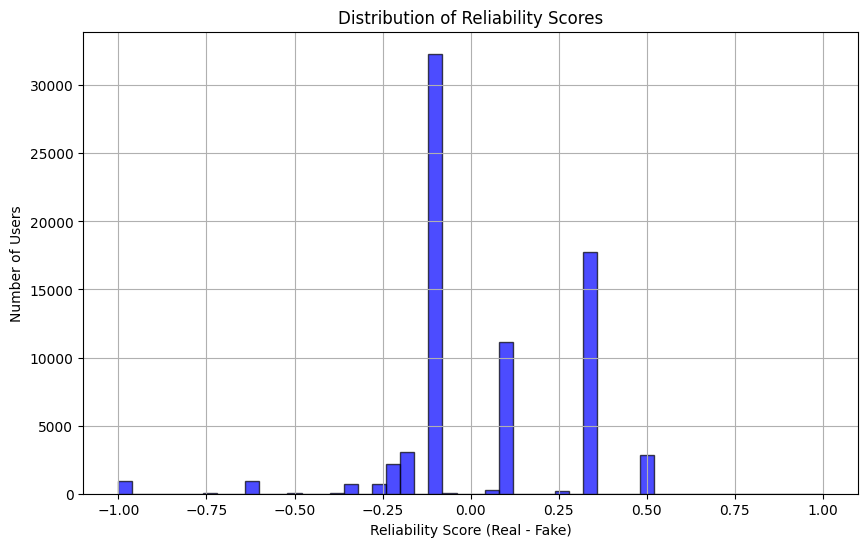

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Extract necessary columns
real_counts = count_all_tweets_pivot["real_normalized"]
fake_counts = count_all_tweets_pivot["fake_normalized"]
scores = count_all_tweets_pivot["score"]

# Plot histogram of reliability scores
plt.figure(figsize=(10, 6))
plt.hist(scores, bins=50, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel("Reliability Score (Real - Fake)")
plt.ylabel("Number of Users")
plt.title("Distribution of Reliability Scores")
plt.grid(True)
plt.show()


# Graph Generation

In [10]:
# Step 1: Create bipartite graph
B = ig.Graph()

# Add news articles as nodes (type 0)
news_articles = df["news_id"].unique().tolist()
news_indices = {news: i for i, news in enumerate(news_articles)}
B.add_vertices(len(news_articles), attributes={"name": news_articles, "type": 0})

# Add users as nodes (type 1)
users = df["tweet_id"].unique().tolist()
user_indices = {user: i + len(news_articles) for i, user in enumerate(users)}
B.add_vertices(len(users), attributes={"name": users, "type": 1})

# Add edges between users and news articles
edges = [(user_indices[row.tweet_id], news_indices[row.news_id]) for row in df.itertuples(index=False)]
B.add_edges(edges)



In [11]:
# Step 2: Project the graph into a user network
user_nodes = [v.index for v in B.vs if v["type"] == 1]  # Extract only user nodes
user_network = B.bipartite_projection(multiplicity=True)[1]  # Project onto users

# Display graph statistics
print("Bipartite Graph:")
print(f" - Number of nodes: {B.vcount()}")
print(f" - Number of edges: {B.ecount()}")

print("\nUser Network Projection:")
print(f" - Number of users: {user_network.vcount()}")
print(f" - Number of connections: {user_network.ecount()}")

# Convert edges to a DataFrame for display
edges_df = pd.DataFrame({
    "user1": [user_network.vs[e.source]["name"] for e in user_network.es],
    "user2": [user_network.vs[e.target]["name"] for e in user_network.es],
    "weight": user_network.es["weight"]
})
display(edges_df.head())

# Save the projected user network
user_network.write_graphml("user_network.graphml")
print("User network saved as 'user_network.graphml'.")


Bipartite Graph:
 - Number of nodes: 75156
 - Number of edges: 187701

User Network Projection:
 - Number of users: 73285
 - Number of connections: 49405895


,user1,user2,weight
0,1018479686261858304,1020820887694553089,2
1,1018479686261858304,1020821239118606337,2
2,1018479686261858304,1020822312465993733,2
3,1018479686261858304,1020822944975446018,2
4,1018479686261858304,1020823945702805504,2


User network saved as 'user_network.graphml'.


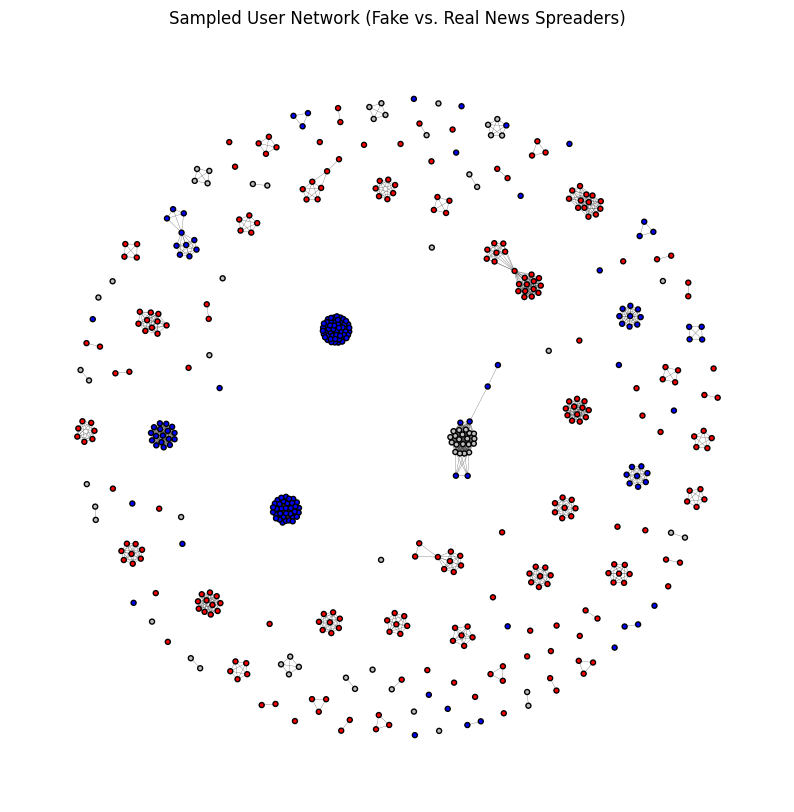

In [27]:
import matplotlib.pyplot as plt
import igraph as ig
import random

# Take a sample of users for visualization (e.g., 500 nodes)
# Convert igraph vertex set to a list of node indices
user_nodes = list(range(user_network.vcount()))

# Take a sample of users for visualization (e.g., 500 nodes)
sampled_users = random.sample(user_nodes, min(500, len(user_nodes)))

# Extract the subgraph with the sampled nodes
subgraph = user_network.subgraph(sampled_users)


# Assign colors based on whether users shared more fake or real news
node_colors = []
for v in subgraph.vs:
    user_id = v["name"]
    user_news = df[df["tweet_id"] == user_id]

    num_fake = len(user_news[user_news["label"] == "fake"])
    num_real = len(user_news[user_news["label"] == "real"])

    if num_fake > num_real:
        node_colors.append("red")  # Fake News Sharer
    elif num_real > num_fake:
        node_colors.append("blue")  # Real News Sharer
    else:
        node_colors.append("gray")  # Mixed Behavior

# Define layout
layout = subgraph.layout_fruchterman_reingold()

# Plot the graph
fig, ax = plt.subplots(figsize=(10, 10))
ig.plot(
    subgraph,
    layout=layout,
    vertex_size=5,
    vertex_color=node_colors,
    edge_width=0.2,
    target=ax
)

plt.title("Sampled User Network (Fake vs. Real News Spreaders)")
plt.show()
